In [27]:
import pandas as pd
import matplotlib.pyplot as plt

In [126]:
import pandas as pd
import numpy as np
import re
import copy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as md


class CreateDataset:
    data_table = None

    def __init__(self, base_dir='', granularity=0):
        self.base_dir = base_dir
        self.granularity = granularity

    # Create an initial data table with entries from start till end time, with steps
    # of size granularity. Granularity is specified in milliseconds
    def create_timestamps(self, start_time, end_time):
        return pd.date_range(start_time, end_time, freq=str(self.granularity)+'ms')

    def create_dataset(self, start_time, end_time, cols, prefix):
        c = copy.deepcopy(cols)
        if not prefix == '':
            for i in range(0, len(c)):
                c[i] = str(prefix) + str(c[i])
        timestamps = self.create_timestamps(start_time, end_time)
        self.data_table = pd.DataFrame(index=timestamps, columns=c)

    # Add numerical data, we assume timestamps in the form of nanoseconds from the epoch
    def add_numerical_dataset(self, file, timestamp_col, value_cols, aggregation='avg', prefix=''):
        print(f'Reading data from {file}')
        dataset = pd.read_csv(self.base_dir + '/' + file, skipinitialspace=True)
        
        # added this line because this is how the app measured the time
        dataset["epoch"] = dataset.apply(lambda row: calc_min_sec_etc(row.Timestamp, row.Milliseconds), axis=1)
        
        # Convert timestamps to dates
        dataset[timestamp_col] = pd.to_datetime(dataset[timestamp_col])

        # Create a table based on the times found in the dataset
        if self.data_table is None:
            self.create_dataset(min(dataset[timestamp_col]), max(dataset[timestamp_col]), value_cols, prefix)
        else:
            for col in value_cols:
                self.data_table[str(prefix) + str(col)] = np.nan

        # Over all rows in the new table
        for i in range(0, len(self.data_table.index)):
            # Select the relevant measurements.
            relevant_rows = dataset[
                (dataset[timestamp_col] >= self.data_table.index[i]) &
                (dataset[timestamp_col] < (self.data_table.index[i] +
                                           timedelta(milliseconds=self.granularity)))
            ]
            for col in value_cols:
                # Take the average value
                if len(relevant_rows) > 0:
                    if aggregation == 'avg':
                        self.data_table.loc[self.data_table.index[i], str(prefix)+str(col)] = np.average(relevant_rows[col])
                    else:
                        raise ValueError(f"Unknown aggregation {aggregation}")
                else:
                    self.data_table.loc[self.data_table.index[i], str(prefix)+str(col)] = np.nan

    # Remove undesired value from the names.
    def clean_name(self, name):
        return re.sub('[^0-9a-zA-Z]+', '', name)

    # Add data in which we have rows that indicate the occurrence of a certain event with a given start and end time.
    # 'aggregation' can be 'sum' or 'binary'.
    def add_event_dataset(self, file, start_timestamp_col, end_timestamp_col, value_col, aggregation='sum'):
        print(f'Reading data from {file}')
        dataset = pd.read_csv(self.base_dir + '/' + file)

        # Convert timestamps to datetime.
        dataset[start_timestamp_col] = pd.to_datetime(dataset[start_timestamp_col])
        dataset[end_timestamp_col] = pd.to_datetime(dataset[end_timestamp_col])

        # Clean the event values in the dataset
        dataset[value_col] = dataset[value_col].apply(self.clean_name)
        event_values = dataset[value_col].unique()

        # Add columns for all possible values (or create a new dataset if empty), set the default to 0 occurrences
        if self.data_table is None:
            self.create_dataset(min(dataset[start_timestamp_col]), max(dataset[end_timestamp_col]), event_values, value_col)
        for col in event_values:
            self.data_table[(str(value_col) + str(col))] = 0

        # Now we need to start counting by passing along the rows....
        for i in range(0, len(dataset.index)):
            # identify the time points of the row in our dataset and the value
            start = dataset[start_timestamp_col][i]
            end = dataset[end_timestamp_col][i]
            value = dataset[value_col][i]
            border = (start - timedelta(milliseconds=self.granularity))

            # get the right rows from our data table
            relevant_rows = self.data_table[(start <= (self.data_table.index +timedelta(milliseconds=self.granularity))) & (end > self.data_table.index)]

            # and add 1 to the rows if we take the sum
            if aggregation == 'sum':
                self.data_table.loc[relevant_rows.index, str(value_col) + str(value)] += 1
            # or set to 1 if we just want to know it happened
            elif aggregation == 'binary':
                self.data_table.loc[relevant_rows.index, str(value_col) + str(value)] = 1
            else:
                raise ValueError("Unknown aggregation '" + aggregation + "'")

    # This function returns the column names that have one of the strings expressed by 'ids' in the column name.
    def get_relevant_columns(self, ids):
        relevant_dataset_cols = []
        cols = list(self.data_table.columns)

        for id in ids:
            relevant_dataset_cols.extend([col for col in cols if id in col])

        return relevant_dataset_cols

In [127]:
def calc_min_sec_etc(date_and_time, millisecond):
    # "2020-06-04 15:18:19"
    date, time = date_and_time.split()
    
    splitted = date.split('-')
    year = int(splitted[0])
    month = int(splitted[1])
    day = int(splitted[2])
    
    splitted = time.split(':')
    hour = int(splitted[0])
    minute = int(splitted[1])
    second = int(splitted[2])
    
    microseconds = millisecond * 1000
    microseconds = microseconds % 1000000
    
    now = int(round(datetime(year, month, day, hour, minute, second, microseconds).timestamp() * 1000000000))
    return now

,Timestamp,Milliseconds,X,Y,Z,epoch
0,2020-06-04 15:18:19,2,-0.620694,4.412396,8.950891,1591276699002000128
1,2020-06-04 15:18:19,11,-0.620694,4.412396,8.950891,1591276699010999808
2,2020-06-04 15:18:19,24,-0.812222,4.407607,8.756968,1591276699024000000
3,2020-06-04 15:18:19,31,-0.723640,4.342967,8.790486,1591276699030999808
4,2020-06-04 15:18:19,43,-0.692517,4.290297,8.788093,1591276699043000064
...,...,...,...,...,...,...
65995,2020-06-04 15:29:19,659966,-0.481836,-5.614090,0.154973,1591277359966000128
65996,2020-06-04 15:29:19,659966,-0.481836,-5.614090,0.154973,1591277359966000128
65997,2020-06-04 15:29:19,659977,-0.481836,-5.614090,0.154973,1591277359976999936
65998,2020-06-04 15:29:19,660018,-0.481836,-5.614090,0.154973,1591277359017999872


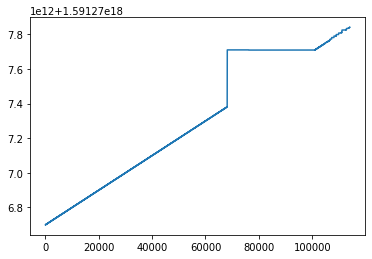

In [128]:
accelerometerdf = pd.read_csv("./recorded_data/Accelerometer.csv")
accelerometerdf["epoch"] = accelerometerdf.apply(lambda row: calc_min_sec_etc(row.Timestamp, row.Milliseconds), axis=1)

plt.plot([x for x in range(len(accelerometerdf.epoch))], accelerometerdf.epoch)

# throw away part of the data where the screen was off and the app did not record
df = accelerometerdf[accelerometerdf.index < 66000]

# plt.plot([x for x in range(len(df.epoch))], df.epoch)
df.to_csv('./recorded_data/Accelerometer_clean.csv')
display(df)

# get the begin/end of where the app did record
begin = 1591276699002000128
end = 1591277359017999872

In [135]:
def create_dataframe(granularity):

    # create a dataframe with given granularity
    df = CreateDataset(base_dir='./recorded_data', granularity=granularity)
    df.create_dataset(start_time=begin, end_time=end, cols = [], prefix='')    
    df.add_numerical_dataset(file='Accelerometer.csv', timestamp_col='epoch', value_cols=['X', 'Y', 'Z'], prefix='acceleration_')
    df.add_numerical_dataset(file='Light.csv', timestamp_col='epoch', value_cols=['Illuminance'], prefix='')
    df.add_numerical_dataset(file='AccelerometerLinear.csv', timestamp_col='epoch', value_cols=['X', 'Y', 'Z'], prefix='accelerationlinear_')
    df.add_numerical_dataset(file='Compass.csv', timestamp_col='epoch', value_cols=['X', 'Y', 'Z'], prefix='compass_')
    df.add_numerical_dataset(file='GPS.csv', timestamp_col='epoch', value_cols=['Latitude', 'Longitude', 'Altitude'], prefix='')
    df.add_numerical_dataset(file='Gravity.csv', timestamp_col='epoch', value_cols=['X', 'Y', 'Z'], prefix='gravity_')
    df.add_numerical_dataset(file='Gyroscope.csv', timestamp_col='epoch', value_cols=['X', 'Y', 'Z'], prefix='gyro_')
    df.add_numerical_dataset(file='RotationVector.csv', timestamp_col='epoch', value_cols=['X', 'Y', 'Z', 'cos', 'headingAccuracy'], prefix='rotation_')
    print("All done\n\n")
    
    return df.data_table

df_g_1000 = create_dataframe(granularity=1000)
df_g_250 = create_dataframe(granularity=250)


Reading data from Accelerometer.csv
Reading data from Light.csv
Reading data from AccelerometerLinear.csv
Reading data from Compass.csv
Reading data from GPS.csv
Reading data from Gravity.csv
Reading data from Gyroscope.csv
Reading data from RotationVector.csv
Reading data from Accelerometer.csv
Reading data from Light.csv
Reading data from AccelerometerLinear.csv
Reading data from Compass.csv
Reading data from GPS.csv
Reading data from Gravity.csv
Reading data from Gyroscope.csv
Reading data from RotationVector.csv


In [137]:
print(df_g_1000.columns)
display(df_g_1000.describe())
display(df_g_250.describe())

Index(['acceleration_X', 'acceleration_Y', 'acceleration_Z', 'Illuminance',
       'accelerationlinear_X', 'accelerationlinear_Y', 'accelerationlinear_Z',
       'compass_X', 'compass_Y', 'compass_Z', 'Latitude', 'Longitude',
       'Altitude', 'gravity_X', 'gravity_Y', 'gravity_Z', 'gyro_X', 'gyro_Y',
       'gyro_Z', 'rotation_X', 'rotation_Y', 'rotation_Z', 'rotation_cos',
       'rotation_headingAccuracy'],
      dtype='object')


,acceleration_X,acceleration_Y,acceleration_Z,Illuminance,accelerationlinear_X,accelerationlinear_Y,accelerationlinear_Z,compass_X,compass_Y,compass_Z,...,gravity_Y,gravity_Z,gyro_X,gyro_Y,gyro_Z,rotation_X,rotation_Y,rotation_Z,rotation_cos,rotation_headingAccuracy
count,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,...,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.0
mean,3.834172,-2.309526,3.862452,3063.573842,0.463937,-0.646035,0.355834,-10.679474,5.394974,-5.801367,...,-1.605652,3.511350,0.012710,0.016298,0.002743,-0.262515,-0.195519,-0.068937,0.568142,0.0
std,4.519940,5.325513,4.632480,4541.831442,1.054242,1.079908,0.722200,22.706566,26.253612,29.171144,...,5.148528,4.892175,0.326219,0.450691,0.410029,0.381205,0.206917,0.510731,0.222454,0.0
min,-7.801994,-12.667106,-6.196499,0.000000,-3.138949,-6.543096,-2.207404,-55.655613,-65.349554,-85.307946,...,-9.804038,-6.399567,-3.061886,-2.557729,-3.031712,-0.803339,-0.705719,-0.970879,0.063704,0.0
25%,0.049891,-5.992832,-0.542653,20.220682,-0.002541,-1.162405,-0.035288,-31.481317,-13.277990,-29.621595,...,-4.817368,-0.894521,-0.094658,-0.114526,-0.105938,-0.655458,-0.336488,-0.467027,0.425435,0.0
50%,2.010953,-2.250788,2.576412,195.147514,0.204686,-0.354651,0.145864,-8.216214,4.979471,-2.130362,...,-1.323527,2.179056,0.003044,-0.000075,-0.009849,-0.271393,-0.195613,-0.057712,0.589659,0.0
75%,9.095246,2.663945,8.790989,4763.753653,0.816098,-0.030782,0.605939,10.006408,24.702396,20.411322,...,3.008622,8.810351,0.131765,0.115391,0.113093,0.079637,-0.030962,0.309572,0.676265,0.0
max,12.647281,8.902456,10.812412,16553.926000,6.892766,4.195469,3.283011,46.465643,56.620975,58.069165,...,8.911905,9.792453,1.722994,2.343667,2.534561,0.855768,0.448897,0.952104,0.995807,0.0


,acceleration_X,acceleration_Y,acceleration_Z,Illuminance,accelerationlinear_X,accelerationlinear_Y,accelerationlinear_Z,compass_X,compass_Y,compass_Z,...,gravity_Y,gravity_Z,gyro_X,gyro_Y,gyro_Z,rotation_X,rotation_Y,rotation_Z,rotation_cos,rotation_headingAccuracy
count,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,...,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.000000,2639.0
mean,3.841528,-2.310477,3.863517,3069.259645,0.464239,-0.649702,0.357760,-10.738025,5.362634,-5.780034,...,-1.600097,3.510657,0.012711,0.014868,0.002060,-0.262431,-0.195617,-0.069774,0.567823,0.0
std,4.847275,5.515329,4.823366,4611.236267,2.050210,2.374198,1.688877,23.170079,26.853823,29.778822,...,5.310094,5.008894,0.949283,0.806553,1.040462,0.392405,0.226625,0.530579,0.228791,0.0
min,-10.387755,-17.306244,-6.820433,0.000000,-7.633741,-15.910569,-8.797700,-70.609416,-66.852174,-89.332179,...,-9.804396,-6.677515,-6.963174,-5.919780,-4.233771,-0.842855,-0.776515,-0.994825,0.012091,0.0
25%,-0.048939,-6.641517,-0.518279,20.045757,-0.525939,-1.435186,-0.451004,-32.100638,-14.610126,-30.771002,...,-5.948352,-1.142872,-0.407018,-0.359227,-0.436287,-0.668351,-0.349866,-0.492889,0.432951,0.0
50%,2.021470,-1.894331,3.043022,189.075556,0.032589,-0.167616,0.086010,-8.894054,5.555696,1.287417,...,-0.483747,2.236837,-0.000586,-0.000160,0.000514,-0.225455,-0.190035,-0.075978,0.584320,0.0
75%,7.982021,2.736963,8.749117,4642.853753,1.025704,0.399505,1.207805,10.092992,25.891022,20.972821,...,3.092182,8.823703,0.325800,0.380066,0.414338,0.085641,-0.022146,0.328118,0.690283,0.0
max,27.267109,14.653392,15.117611,17998.049000,19.407305,7.052468,9.782093,47.109655,59.549000,65.898391,...,9.663874,9.792683,6.337589,5.256844,6.651300,0.878247,0.594565,0.996866,0.998495,0.0


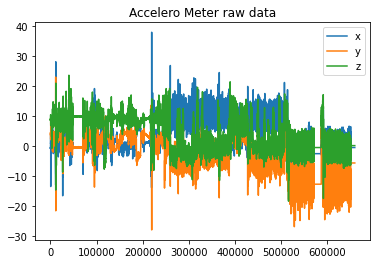

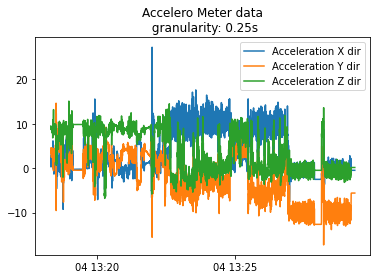

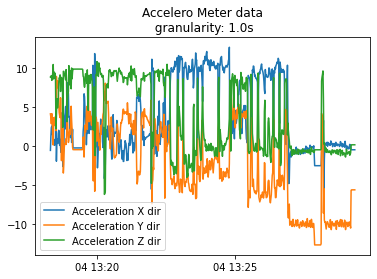

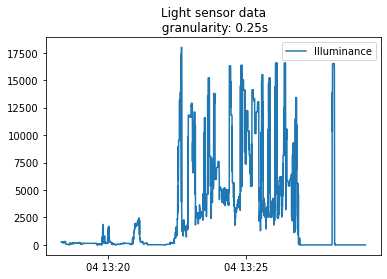

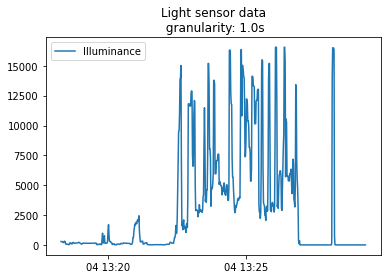

In [138]:
plt.figure()
plt.title("Accelero Meter raw data")
plt.plot(df["Milliseconds"], df["X"], label="x")
plt.plot(df["Milliseconds"], df["Y"], label='y')
plt.plot(df["Milliseconds"], df["Z"], label='z')
plt.legend()

def make_acceleration_plot(df, granularity):
    granularity = str(granularity / 1000) + 's'
    plt.figure()
    plt.title("Accelero Meter data\n granularity: " + granularity)
    plt.plot(df.index, df["acceleration_X"], label="Acceleration X dir")
    plt.plot(df.index, df["acceleration_Y"], label="Acceleration Y dir")
    plt.plot(df.index, df["acceleration_Z"], label="Acceleration Z dir")
    plt.legend()
    
def make_illuminance_plot(df, granularity):
    granularity = str(granularity / 1000) + 's'
    plt.figure()
    plt.title("Light sensor data\n granularity: " + granularity)
    plt.plot(df.index, df["Illuminance"], label="Illuminance")
    plt.legend()
    

make_acceleration_plot(df_g_250, 250)
make_acceleration_plot(df_g_1000, 1000)

make_illuminance_plot(df_g_250, 250)
make_illuminance_plot(df_g_1000, 1000)

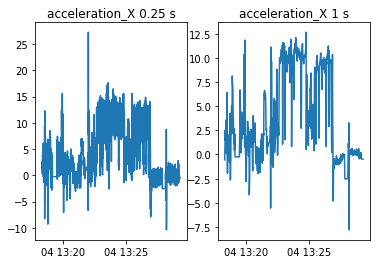

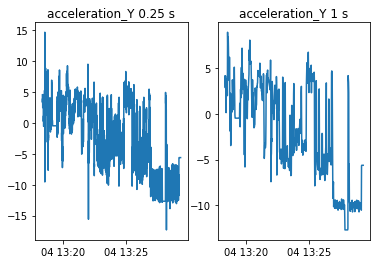

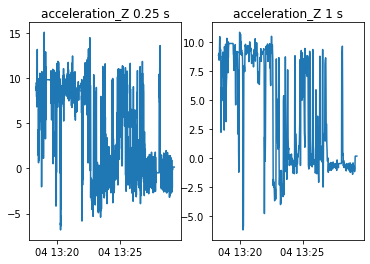

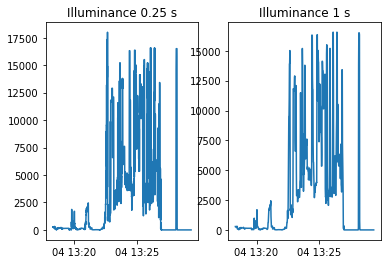

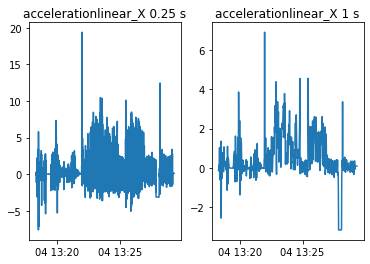

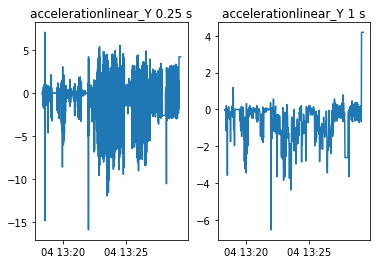

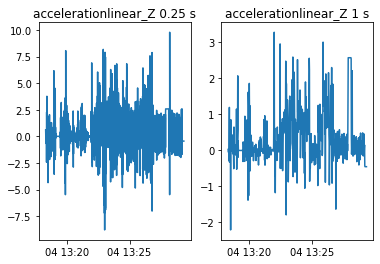

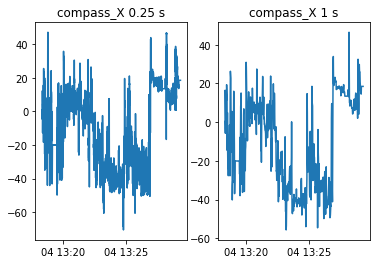

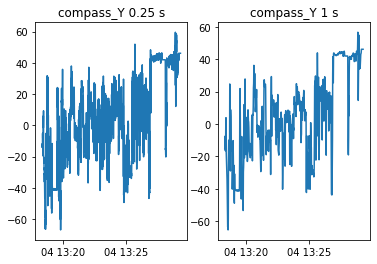

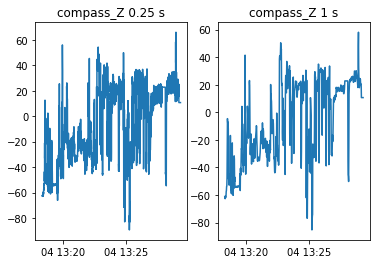

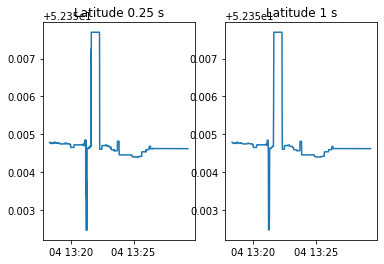

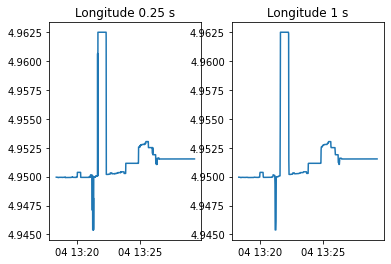

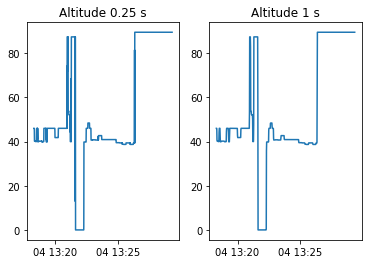

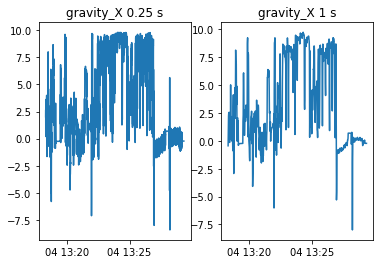

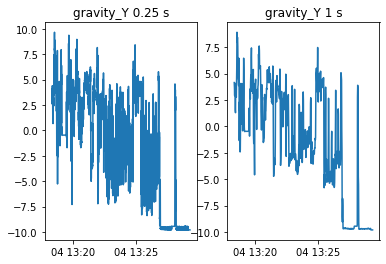

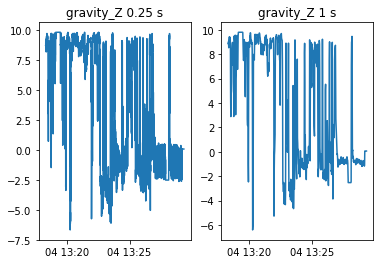

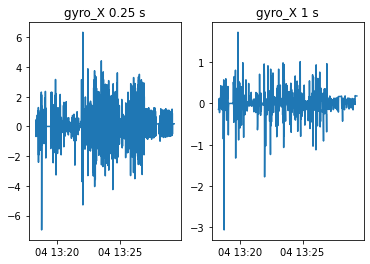

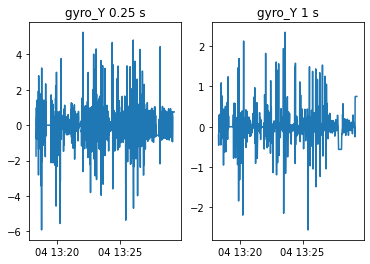

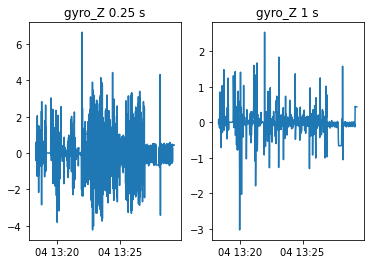

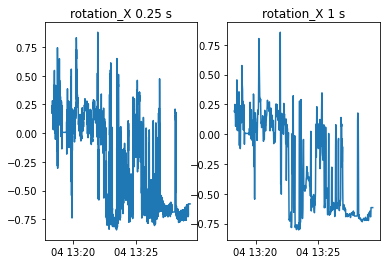

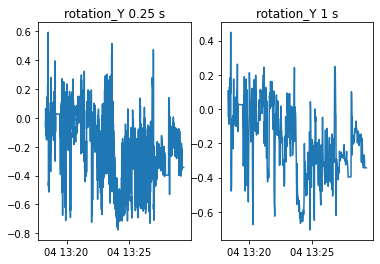

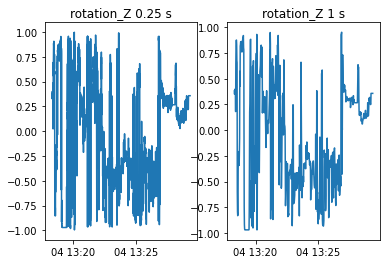

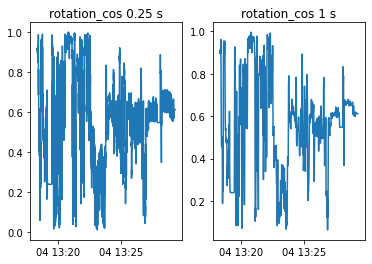

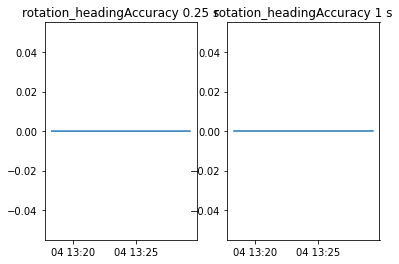

In [152]:
for col in df_g_250.columns:
    # display images
    fig, ax = plt.subplots(1,2)

    ax[0].set_title(str(col) + ' ' + str(0.25) + ' s')
    ax[1].set_title(str(col) + ' ' + str(1) + ' s')

    ax[0].plot(df_g_250.index, df_g_250[col], label=str(col))
    ax[1].plot(df_g_1000.index, df_g_1000[col], label=str(col))
    plt.show()